# Personal Spotify Data Analysis

### Import JSON Spotify data

#### Import libraries

In [596]:
import pandas as pd
import re as re
import matplotlib as mpl
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.pyplot import figure
import datetime
import scipy.stats as stats
from scipy.stats import poisson
from scipy.stats import gamma

#### Import data, vertical stack dataframes, and view data header

In [604]:
artistdf = pd.read_csv('~/Desktop/MyData/artists.csv')
df1 = pd.read_json ('~/Desktop/MyData/StreamingHistory0.json') # import data
df2 = pd.read_json ('~/Desktop/MyData/StreamingHistory1.json')
df = pd.concat([df1,df2]) # Combine data from first half of year with data from second half of year
df['endTime'] = pd.to_datetime(df['endTime'], infer_datetime_format=True).dt.date # Convert endtime to datetime format
df['Hours'] = df['msPlayed']/(3600*1000) # Convert ms to hrs, create new 'Hours' column
df.head() # view data

,endTime,artistName,trackName,msPlayed,Hours
0,2020-09-19,deadmau5,Arguru,151553,0.042098
1,2020-09-20,deadmau5,Arguru,40913,0.011365
2,2020-09-20,Gavin Burrough,Playing Cards,203145,0.056429
3,2020-09-20,Darkest Hour,DEMON(S),228920,0.063589
4,2020-09-21,Football Weekly,Raúl Jiménez: the best No 9 in the Premier Lea...,1832643,0.509068


#### Group by artist name and convert milliseconds to hours

In [591]:
by_artist_name = df.groupby(df['artistName']).sum() # Group by artistname. Sum playtime for each artist
by_artist_name.sort_values(by = ['msPlayed'],axis='index',inplace = True,ascending = False) # Sort artists by playtime
by_artist_name = by_artist_name.reset_index()
by_artist_name.head() # view data

,artistName,msPlayed,Hours
0,Above & Beyond,256707098,71.307527
1,Football Weekly,243516987,67.643607
2,Hot Takedown,157802753,43.834098
3,Planet Money,143049139,39.735872
4,Halo - Mission Debrief,105473603,29.298223


#### Show results as a horizontal bar chart

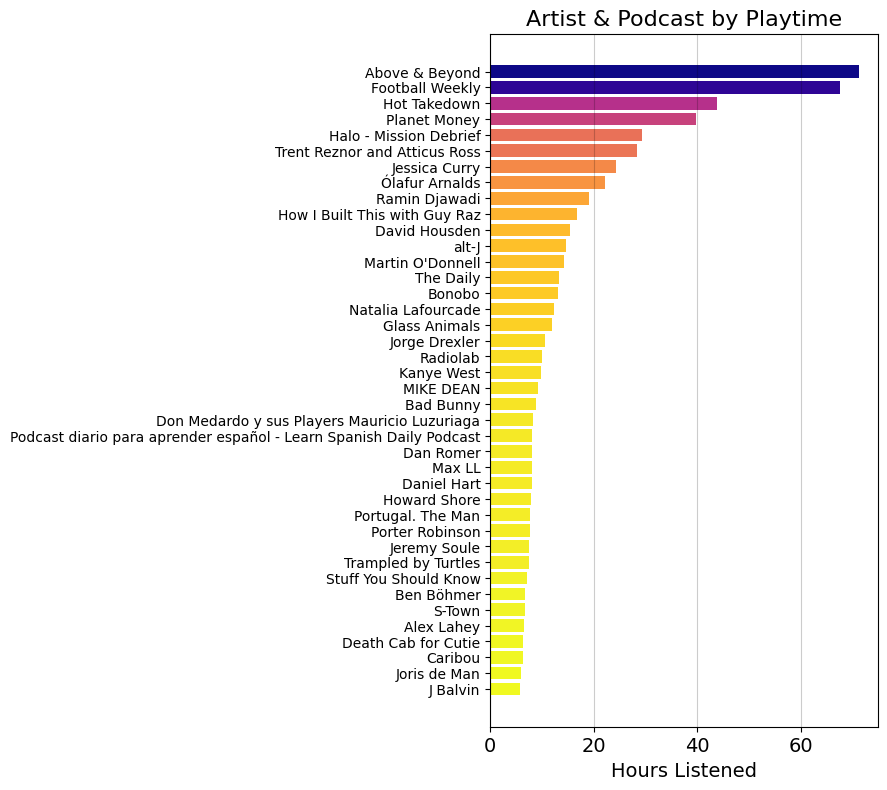

In [439]:
endindex = 40
startindex = 0
fig, ax = plt.subplots(figsize=(5,9))
artists = by_artist_name['artistName'][startindex:endindex][::-1] # Assign artists variable and reverse order
time = by_artist_name['Hours'][startindex:endindex][::-1] # Set and reverse the playtime associated with each artist
y_pos = np.arange(len(artists)) 
my_cmap = plt.get_cmap("plasma")
rescale = lambda y: 1-(y - np.min(y)) / (np.max(y) - np.min(y)) # scale y values for color map
ax.barh(y_pos, time, align='center', color=my_cmap(rescale(time)))
ax.set_yticks(y_pos)
ax.set_yticklabels(artists,fontsize=10)
ax.set_xlabel('Hours Listened',fontsize=14) # 
ax.tick_params(axis='x', labelsize= 14)
ax.set_title(f'Artist & Podcast by Playtime',fontsize=16)
plt.grid(axis='x',color = 'black',alpha = 0.2)
plt.show()

Very nice! It appears that Above & Beyond is indeed above and beyond, outperforming even The Guardian Football Weekly! Ten of the top 40 positions are occupied by podcasts, including positions 2-4, just behind Above & Beyond. From these data, it can be concluded that my past year of listening has largely been defined by EDM and the EPL. Taken together, I streamed approximately 83% of a week of just Above & Beyond and Football Weekly over the past year. 

#### Group by artist name

In [440]:
by_song_name = df.copy()
by_song_name['Song - Artist'] = by_song_name['trackName'] + " by " + by_song_name['artistName']
by_song_name = by_song_name.groupby(by_song_name['Song - Artist']).sum()
by_song_name.sort_values(by = ['msPlayed'],axis='index',inplace = True,ascending = False)
by_song_name.head()

,msPlayed,Hours
Song - Artist,,
Counting the Atmospheres by Jessica Curry,15498946,4.305263
Another Chance - Live At The Hollywood Bowl by Above & Beyond,13988258,3.885627
The Mountain Between Us by Ramin Djawadi,12506179,3.473939
Counting Down The Days / Liquid Love - Live At The Hollywood Bowl by Above & Beyond,11543883,3.206634
The Growing of the World by Jessica Curry,10887987,3.024441


#### Visualize as a horizontal bar chart

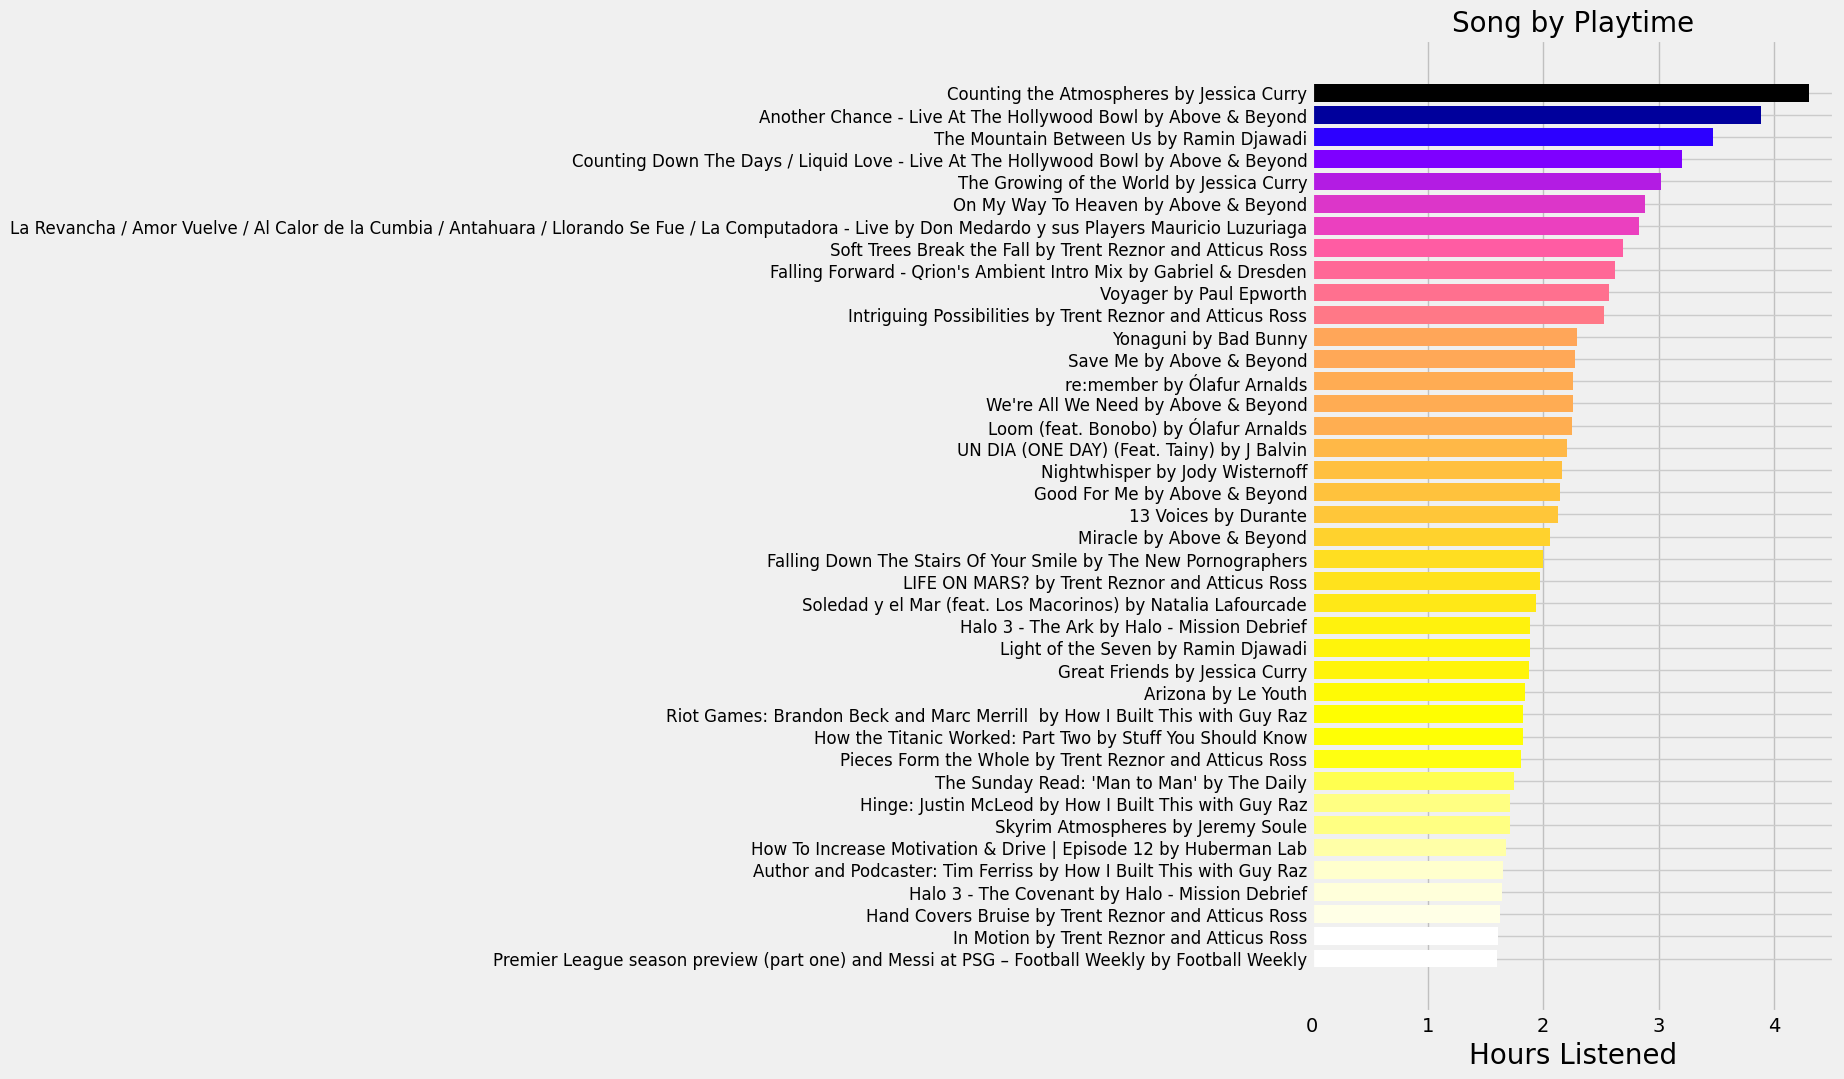

In [441]:
endindex = 40
startindex = 0
plt.style.use('fivethirtyeight')
fig, ax = plt.subplots(figsize=(6,12))
artists = by_song_name.index[startindex:endindex][::-1]
time = by_song_name['Hours'][startindex:endindex][::-1]
y_pos = np.arange(len(artists)) 
my_cmap = plt.get_cmap("gnuplot2")
rescale = lambda y: 1-(y - np.min(y)) / (np.max(y) - np.min(y))
ax.barh(y_pos, time, align='center', color=my_cmap(rescale(time)))
ax.set_yticks(y_pos)
ax.set_yticklabels(artists,fontsize=12)
ax.set_xlabel('Hours Listened',fontsize=20) # 
ax.tick_params(axis='x', labelsize= 14)
ax.set_title(f'Song by Playtime',fontsize=20)
plt.grid(axis='x',color = 'black',alpha = 0.2)
plt.show()

My habits of podcasts while working out and soundtracks while studying is on full display in this visualization. Lots of ethereal tracks on repeat apparently make for good work conditions. Some longer podcast episodes start to appear in the sub-two hour range. 

#### Now let's look at my listening over the course of the year

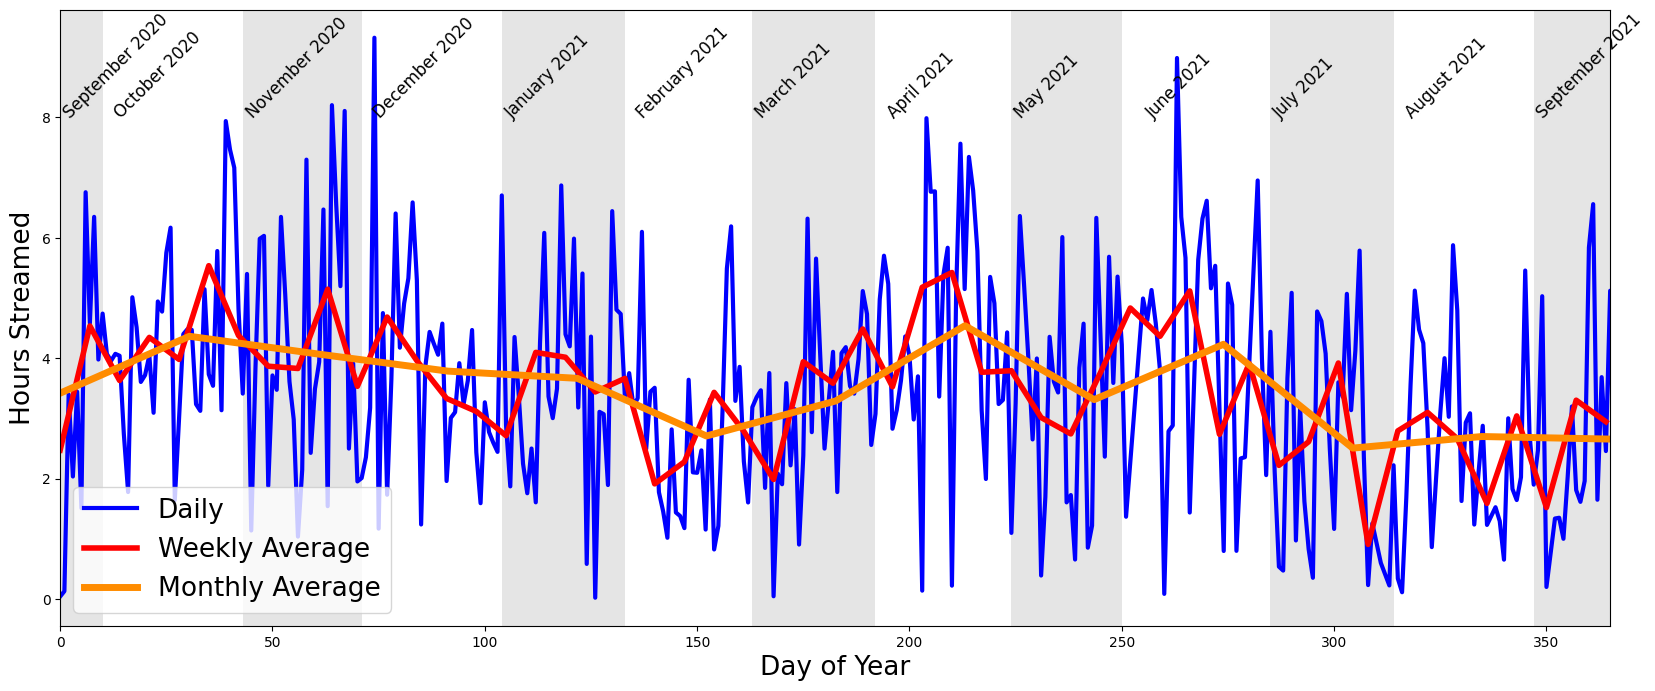

In [442]:
plt.style.use('default')
plt.subplots(figsize=(20,8))
by_year = df.copy()
by_year = by_year.groupby(by_year['endTime']).sum()
by_year['dayofyear'] = list(map(lambda x: (x - by_year.index[0]).days,by_year.index))
by_year['written'] = list(map(lambda x: x.strftime("%B %Y"),by_year.index))
by_year['week'] = np.floor(by_year['dayofyear']/7)
by_year = by_year.reset_index()
by_year.columns = ['endTime','ms','Hours', 'dayofyear', 'written','week']
monthly = by_year.copy()
monthly = monthly.groupby(['written']).mean() 
monthly = monthly.reset_index()
monthly['Date'] = pd.to_datetime(monthly.written)
monthly = monthly.sort_values(by = ['Date']).reset_index()

plt.plot(by_year['dayofyear'],by_year['Hours'],color = 'blue',linewidth = 3, label = 'Daily')

by_year_wk = by_year.groupby(['week']).mean()
by_year_wk = by_year_wk.reset_index()


dates = [0 for i in monthly.index]
j = 0
for i in monthly.index:
    montharray = []
    while j < len(by_year)-1 and by_year['written'][j] == by_year['written'][j+1]:
        montharray.append(by_year['dayofyear'][j])
        j = j+1
    dates[i] = np.array(montharray)
    j = j+1
for k in range(0,len(dates)):
    if k %2 == 0:
        plt.axvspan(dates[k].min(),dates[k].max(),facecolor = 'grey', alpha = 0.2)
        plt.annotate(monthly.iloc[k]['written'],(dates[k].min(),8),fontsize = 12, color = "black", rotation = 45)
    else:
        plt.axvspan(dates[k].min(),dates[k].max(),facecolor = 'white', alpha = 0.1)
        plt.annotate(monthly.iloc[k]['written'],(dates[k].min(),8),fontsize = 12, color = "black", rotation = 45)


plt.plot(by_year_wk['week']*7,by_year_wk['Hours'],color = 'red',linewidth = 4,label = 'Weekly Average')
plt.plot(monthly.index*30.437,monthly['Hours'],color = 'darkorange',linewidth = 5, label = 'Monthly Average')
plt.xlabel("Day of Year",fontsize=19)
plt.ylabel("Hours Streamed",fontsize=19)
plt.legend(loc = 'lower left',fontsize=19)
plt.xlim(0,by_year['dayofyear'].max()-1)
plt.show()

#### This seems messy. We can make something that's a little more visually pleasing...

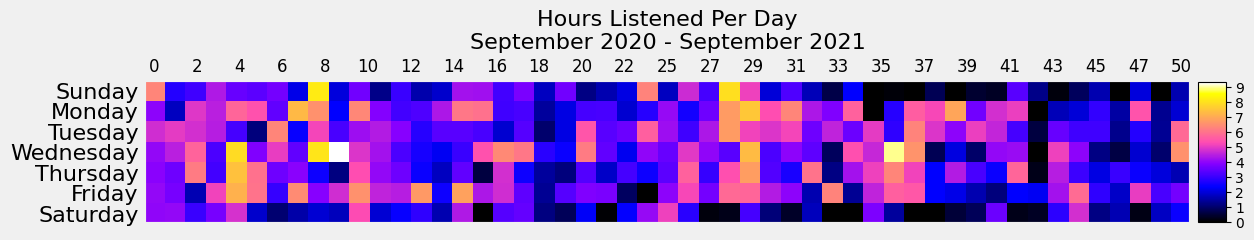

In [443]:
year = df.copy()
year = year.groupby(year['endTime']).sum()
year = year.reset_index()
year['dayofyear'] = list(map(lambda x: (x - year['endTime'][0]).days,year['endTime']))
year['week'] = np.floor(year['dayofyear']/7)

weeks, j = np.zeros(371,float), 0
for i in year['dayofyear']:
    year.iloc[j]   
    weeks[i] = year.iloc[j]['Hours']
    j = j+1

weeks = np.roll(weeks,-1).reshape(-1,7).T #Roll to make sundayfirst day, reshape to 7 days per week, transpose for viz
weeks = np.delete(weeks, [0,-1],axis=1)# Delete the first and last week that had incomplete data. 
plt.style.use('fivethirtyeight')
#plt.style.use('default')
plt.matshow(weeks, cmap='gnuplot2')
plt.grid(None)
plt.yticks(ticks = [0,1,2,3,4,5,6],labels = 
           ['Sunday','Monday','Tuesday','Wednesday','Thursday','Friday','Saturday'],fontsize=16)
plt.xticks(ticks = np.linspace(0,50,25),labels = (np.linspace(0,50,25,dtype=int)),fontsize=12)
plt.title("Hours Listened Per Day\nSeptember 2020 - September 2021",fontsize=16)
plt.style.use('default')
plt.colorbar(ticks=range(0,10), aspect = 5, pad =0.005,shrink = 0.82)
plt.show()

#### Alternate visualization, perhaps even more visually pleasing...

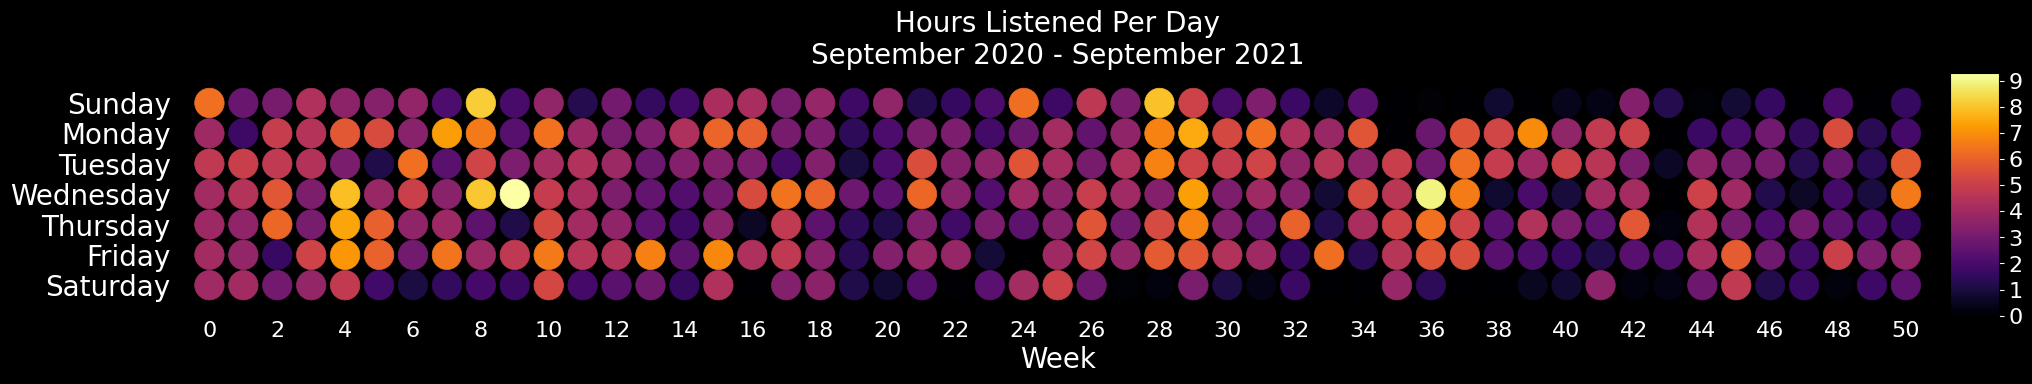

In [522]:
year = df.copy()
year = year.groupby(year['endTime']).sum()
year = year.reset_index()
year['dayofyear'] = list(map(lambda x: (x - year['endTime'][0]).days,year['endTime']))
year['week'] = np.floor(year['dayofyear']/7)

weeks, j = np.zeros(371,float), 0
for i in year['dayofyear']:
    year.iloc[j]   
    weeks[i] = year.iloc[j]['Hours']
    j = j+1

    
weeks = np.roll(weeks,-1).reshape(-1,7).T #Roll to make sundayfirst day, reshape to 7 days per week, transpose for viz
weeks = np.delete(weeks, [0,-1],axis=1)# Delete the first and last week that had incomplete data. 
plt.style.use('fivethirtyeight')
fig, ax = plt.subplots(figsize=(24,3))
fig.patch.set_facecolor('black')
X,Y = np.meshgrid(np.arange(weeks.shape[1]), np.arange(weeks.shape[0]))

ax.set_facecolor('black')
#ax.axis('off')
plt.scatter(X.flatten(), abs(Y.flatten()-6), c=weeks.flatten(), cmap='inferno',s = 450)

plt.grid(None)
plt.yticks(ticks = [6,5,4,3,2,1,0],labels = 
           ['Sunday','Monday','Tuesday','Wednesday','Thursday','Friday','Saturday'],fontsize=20, color = 'w')
plt.xticks(ticks = np.linspace(0,50,26),labels = (np.linspace(0,50,26,dtype=int)),fontsize=16, color = 'w')
plt.title("Hours Listened Per Day\nSeptember 2020 - September 2021",fontsize=20, color = 'w')
plt.ylim(-1,7)
plt.xlabel("Week",fontsize=20, color = 'w')
plt.style.use('default')
cbar = plt.colorbar(ticks=range(0,10), aspect = 5, pad =0.005)
cbar.ax.tick_params(axis='y', colors='w',labelsize=16)
plt.xlim(-1,51)
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['bottom'].set_visible(False)
ax.spines['left'].set_visible(False)
plt.show()

It looks like I listen to less Spotify on Saturdays and Sundays. I can rationalize this because normally I'm out and about on the weekends and away from my laptop where I listen to the majority of my music while working and studying. The majority of my weekend streaming comes from podcasts that I listen to while out on long solo weekend rides. Week 43 is notable for the low amount of streaming. I was in Maine that week and largely off the grid so streaming was minimal. 

#### Distribution of listening time per day

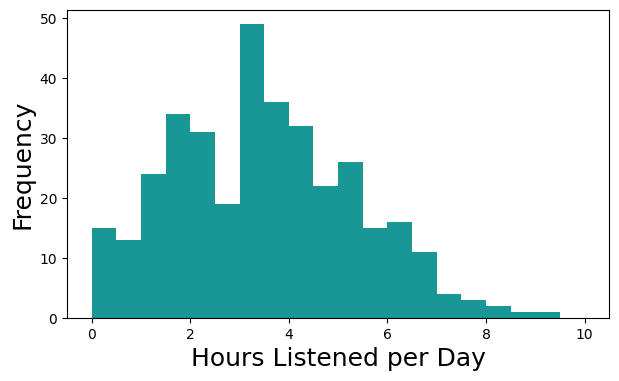

In [523]:
histdf = df.copy()
histdf['endTime'] = pd.to_datetime(histdf['endTime'], infer_datetime_format=True).dt.date
histdf = histdf.groupby(histdf['endTime']).sum()
fig, ax = plt.subplots(figsize=(7,4))
plt.hist(histdf['Hours'],bins=20,range = (0,10), color = 'darkcyan', histtype = 'stepfilled',alpha = 0.9)
plt.xlabel("Hours Listened per Day",fontsize=18)
plt.ylabel('Frequency',fontsize=18)
plt.show()

#### Let's dig into these data a little more

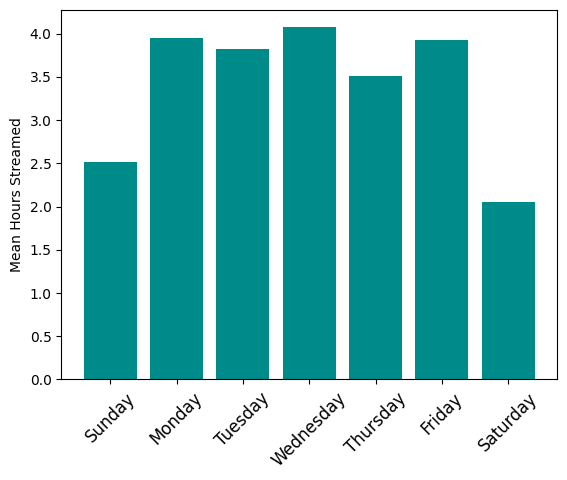

In [524]:
plt.bar(np.linspace(1,7,7), np.mean(weeks,axis=1),color = 'darkcyan')
plt.xticks(ticks = np.linspace(1,7,7),labels = 
           ['Sunday','Monday','Tuesday','Wednesday','Thursday','Friday','Saturday'],fontsize=12, rotation=45)
plt.ylabel("Mean Hours Streamed")
plt.show()

#### We can further group our data by weekday and weekend

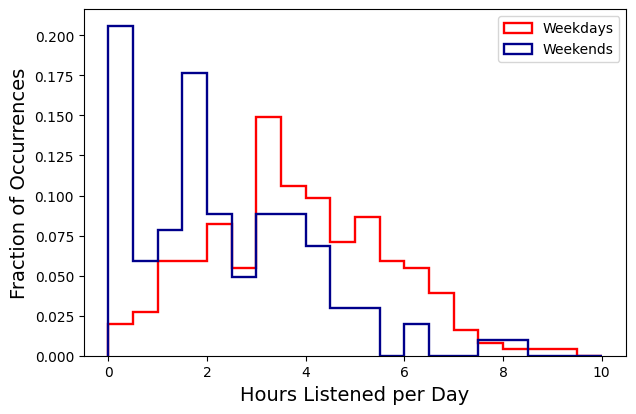

In [606]:
weekends = np.concatenate((weeks[0],weeks[6]))
weekdays = weeks[1:6].flatten()
wks = np.ones_like(weekdays)/float(len(weekdays))
wkds = np.ones_like(weekends)/float(len(weekends))
plt.style.use('default')
fig, ax = plt.subplots(figsize=(7,4.5))
plt.hist(weekdays,bins=20,range=(0,10),color = 'red',histtype = 'step',label = "Weekdays",weights=wks,linewidth=1.7,bottom = 0.0001)
plt.hist(weekends,bins=20,range=(0,10),color = 'darkblue',histtype = 'step',label = "Weekends",weights=wkds,linewidth=1.7,bottom = 0.0001)
plt.xlabel("Hours Listened per Day",fontsize=14)
plt.ylabel('Fraction of Occurrences',fontsize=14)
plt.legend()
plt.show()

#### Is the difference between the amount of weekday streaming and weekend streaming statistically significant?
First test for normality of the weekday data and the weekend data

In [526]:
stats.normaltest(weekdays)

NormaltestResult(statistic=2.197236821336632, pvalue=0.3333312926728444)

Weekday data is normally distributed

In [527]:
stats.normaltest(weekends)

NormaltestResult(statistic=12.973505549923653, pvalue=0.001523488093249107)

Weekend data, however, is not normally distributed. We will proceed with the nonparametric Kruskal-Wallis test.

In [528]:
stats.kruskal(weekdays,weekends)

KruskalResult(statistic=50.053402342422324, pvalue=1.4961814054404624e-12)

According to the test, we reject the null hypothesis that there is no difference between the amount of weekend streaming and the amount of weekday streaming. In other words, there is a statistically significant difference between the amount that I stream on weekends and the amount that I stream on weekdays.

#### Is my streaming statistically the same for all five weekdays?
First, test for the equality of standard deviations (homoscedasticity)

In [529]:
stats.bartlett(weeks[1],weeks[2],weeks[3],weeks[4],weeks[5])

BartlettResult(statistic=8.922660899929024, pvalue=0.06306193011508963)

All variances are equal. Now we test that the data from all five weekdays are normal. 

In [530]:
print(f'Mon p-value: {stats.normaltest(weeks[1:6],axis=1)[1][0]:.3f}\nTue p-value: {stats.normaltest(weeks[1:6],axis=1)[1][1]:.3f}\nWed p-value: {stats.normaltest(weeks[1:6],axis=1)[1][2]:.3f}\nThu p-value: {stats.normaltest(weeks[1:6],axis=1)[1][3]:.3f}\nFri p-value: {stats.normaltest(weeks[1:6],axis=1)[1][4]:.3f}')

Mon p-value: 0.383
Tue p-value: 0.747
Wed p-value: 0.455
Thu p-value: 0.429
Fri p-value: 0.300


According to the test for normality, all five weekday distributions are indeed normal. We can now proceed with one-way ANOVA test.

In [531]:
stats.f_oneway(weeks[1],weeks[2],weeks[3],weeks[4],weeks[5])

F_onewayResult(statistic=0.6998541328938123, pvalue=0.592702671918758)

According to this result, we accept the null hypothesis that I stream the same amount on each weekday. 

In [605]:
artistdf.rename(columns={"ARTIST NAME": "artistName"},inplace = True)
artistdf = artistdf.convert_dtypes()
artistdf['LEAD STREAMS'] = list(map(lambda x: int(x.replace(',', '')), artistdf['LEAD STREAMS']))
type(artistdf['LEAD STREAMS'][0])

# grp = df.copy()
# grp = df.groupby(by = ['artistName']).sum()
# merged = artistdf.merge(grp, how = 'inner', on = 'artistName')
# merged

numpy.int64

In [577]:
artistdf['TRACKS'].dtype

dtype('O')

In [538]:
# merged['perstream'] = merged['LEAD STREAMS']
# merged
# change type of df array

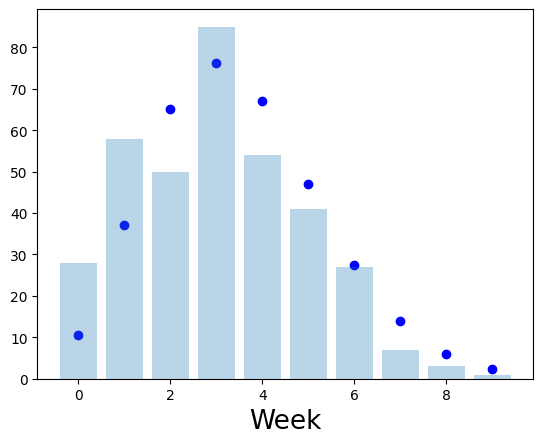

In [487]:
# Chi-square goodness of fit for the poisson distribution
fitdf = df.copy()
fitdf = fitdf.groupby(fitdf['endTime']).sum()
fitdf['bins'] = np.floor(fitdf['Hours'])
fitdf = fitdf.groupby(fitdf['bins']).count()
fitdf['poisson'] = fitdf['msPlayed']/(fitdf['msPlayed'].sum())
fitdf = fitdf.reset_index()
x = np.arange(0, 10, 1)

#y = gamma.pdf(x, 0.8659332175069112 , loc=100.08697963283467,scale = 21.739518937816108)*df['msPlayed'].sum()
#plt.scatter(x, y, color = "blue") # *len(df['Hours']
            
y = poisson.pmf(x, mu, loc=0)*fitdf['msPlayed'].sum()          
plt.scatter(x, y, color = "blue") 

plt.bar(fitdf['bins'],fitdf['Hours'],alpha = 0.3)
plt.xlabel("Week",fontsize=19)
plt.show()

In [433]:
# GO TO THE STRAVA DATA TO DO WEEK PLOT FOR 7 YEARS
# ADD MONTH TO WEEK PLOT 
# MAKE A FUNCTION WHERE YOU ENTER ARTIST NAME AND IT VISUALIZES THE DAYS LISTENED IN THE PAST YEAR

In [488]:
a = ((fitdf['Hours']- y)**2)/y
print(a.sum())
stats.chisquare(fitdf['Hours'], y, ddof = len(fitdf['Hours'])-1)
# 0    28
# 1    58
# 2    50
# 3    85
# 4    54
# 5    41
# 6    27
# 7     7
# 8     3
# 9     1
#len(df['Hours'])-1

54.309032369732286


Power_divergenceResult(statistic=54.309032369732286, pvalue=nan)

In [491]:
fit_alpha, fit_loc, fit_beta=stats.gamma.fit(fitdf['Hours'])
print(fit_alpha, fit_loc, fit_beta)
# (5.0833692504230008, 100.08697963283467, 21.739518937816108)

print(fit_alpha, fit_loc, fit_beta)
# (5, 100.5, 22)

0.8659332175069112 0.9999993362810322 27.047048416467625
0.8659332175069112 0.9999993362810322 27.047048416467625


In [121]:
# from scipy.stats import poisson
# x = np.arange(0, 14, 1)
# mu = np.mean(df['Hours'])
# mu
# y = poisson.pmf(x, mu, loc=0)
 
# plt.scatter(x, y)

# plt.show()



#bins = np.linspace(0,10,11)
# labels = ['zero','one','two','three','four','five','six','seven','eight','nine']

# df['bins'] = pd.cut(df['Hours'], bins=bins, labels=labels, include_lowest=True)
# df['bins']

# plt.hist(df['bins'], bins=10)


# figure(figsize=(5, 10), dpi=80)
# #plt.plot(df['Hours'][:50],df.index[:50])
# plt.plot(df['Hours'][:30][::-1],df.index[:30][::-1])
# plt.xlabel("Hours",fontsize=20)
# plt.ylabel("Artist/Podcast", fontsize=20)
# plt.show()


#df['endTime'] = pd.to_datetime(df['endTime']).dt.date

#written = np.array(df.index)
#written
#  is True,     .strftime("%b %d %Y")
#x = datetime.datetime(2018, 5, 12, 2, 25, 50, 13)
#print(x.strftime("%b %d %Y %H:%M:%S"))

# plt.subplots(figsize=(20,8))
# plt.bar(ls,df['Hours'])
# plt.show()
    
# b = df.index[2] - df.index[0]
# b.days

# x = np.arange(len(df['Hours']))

# plt.subplots(figsize=(20,8))
# plt.bar(x,df['Hours'])
# plt.show()


#df = df.groupby(df['Song - Artst']).sum()
#df.sort_values(by = ['msPlayed'],axis='index',inplace = True,ascending = False)
#df['Hours'] = df['msPlayed']/(3600*1000)

#x = datetime.datetime(2018, 5, 12, 2, 25, 50, 13)
#print(x.strftime("%b %d %Y %H:%M:%S"))

# ls = []
# for i in range(len(df['Hours'])):
#     ls.append((df.index[i]-df.index[0]).days)

# for i in range(0,366):
#     if i in df['dayofyear']:
#         dfnew.append()

# for i in df['dayofyear']:
#     print(df.iloc[i]['dayofyear']) 
#     print(i)
#     != df.iloc[i]['dayofyear']


# for i in df.index:
#     print(i)
# df = pd.concat([df.iloc[:1], new_df, df.iloc[1:]], ignore_index = True)
# b = np.array(df['dayofyear'])
# b = np.array(np.arange(0,364)).reshape(7,-1)
# b
# a = np.where(b in df['dayofyear'],b,0)


# by_year = df.copy()
# by_year = by_year.groupby(df['endTime']).sum()
# by_year['dayofyear'] = list(map(lambda x: (x - by_year.index[0]).days,by_year.index))
# by_year['written'] = list(map(lambda x: x.strftime("%B %Y"),by_year.index))
# by_year['week'] = np.floor(by_year['dayofyear']/7)



# by_year = by_year.groupby(['week']).agg({'Hours':['mean','min','max']})
# by_year = by_year.reset_index()
# by_year.columns = ['week','hrs_mean', 'hrs_min', 'hrs_max']


# plt.subplots(figsize=(20,8))
# plt.bar(by_year['week'],by_year['hrs_mean'])
# plt.xlabel("Week",fontsize=19)
# plt.show()

# dates = [0 for i in monthly.index]
# j = 0
# for i in monthly.index:
#     montharray = []
#     while j < len(by_year)-1 and by_year['written'][j] == by_year['written'][j+1]:
#         montharray.append(by_year['dayofyear'][j])
#         j = j+1
#     dates[i] = np.array(montharray)
#     j = j+1
# for k in range(0,len(dates)):
#     if k %2 == 0:
#         plt.axvspan(dates[k].min(),dates[k].max(),facecolor = 'grey', alpha = 0.2)
#         plt.annotate(monthly.iloc[k]['written'],(dates[k].min(),8),fontsize = 16, color = "black")
#     else:
#         plt.axvspan(dates[k].min(),dates[k].max(),facecolor = 'white', alpha = 0.1)
#         plt.annotate(monthly.iloc[k]['written'],(dates[k].min(),8),fontsize = 16, color = "black")


# plt.annotate("Station 2",(3,5800),fontsize = 16, color = "black")
# plt.annotate("Station 7",(5.83,5800),fontsize = 16, color = "black")
# plt.annotate("Station 12",(7.97,5800),fontsize = 16, color = "black")
# plt.annotate("WM",(10.1,5800),fontsize = 16, color = "black")

# histdf['dayofyear'] = list(map(lambda x: (x - histdf.index[0]).days,histdf.index))
# histdf['writtendate'] = list(map(lambda x: x.strftime("%B %d %Y"),histdf.index))
# df['written'] = list(map(lambda x: x.strftime("%b %d %Y"),df.index))
# plt.style.use('fivethirtyeight')
# plt.hist(df['Hours'],bins=10,range = (df['Hours'].min(),df['Hours'].max()+3)
# plt.subplots(figsize=(20,8))
# plt.bar(df['dayofyear'],df['Hours'])
# plt.show()
# df['endTime'] = pd.to_datetime(df['endTime'], infer_datetime_format=True)
# year['written'] = list(map(lambda x: x.strftime("%B %Y"),year['endTime']))

In [380]:
# df1 = pd.read_json ('~/Desktop/MyData/StreamingHistory0.json')
# df2 = pd.read_json ('~/Desktop/MyData/StreamingHistory1.json')
# df = pd.concat([df1,df2],ignore_index = True)
# df['endTime'] = pd.to_datetime(df['endTime'], infer_datetime_format=True).dt.date
# df = df.groupby(df['endTime']).sum()
# df['Hours'] = df['msPlayed']/(3600*1000)
# df['dayofyear'] = list(map(lambda x: (x - df.index[0]).days,df.index))
# #df['written'] = list(map(lambda x: x.strftime("%b %d %Y"),df.index))
# df['written'] = list(map(lambda x: x.strftime("%B %Y"),df.index))
# df['week'] = np.floor(df['dayofyear']/7)
# df = df.groupby(['written']).agg({'Hours':['mean','min','max']})
# df = df.reset_index()
# df.columns = ['date','hrs_mean', 'hrs_min', 'hrs_max']
# df['Date'] = pd.to_datetime(df.date)
# df = df.sort_values(by = ['Date']).reset_index()

# plt.style.use('seaborn')
# plt.subplots(figsize=(20,8))
# plt.bar(df.index,df['hrs_mean'],tick_label = df['date'])
# plt.xticks(rotation=90,fontsize=19)
# plt.ylabel("Average Hours Listened",fontsize=19)
# plt.show()
# df